#  <span style="color:beige">Del 2 - Analys av diamantdata – Data Story </span>

I denna analys undersöker vi ett dataset innehållande över 50 000 diamanter.  
Syftet är att analysera mönster och insikter kopplat till pris, storlek, färg, klarhet och slipning.

Vi arbetar för ett företag som överväger att investera i diamanter. Denna analys hjälper till att förstå marknaden bättre och ge rekommendationer för framtida beslut.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import umap.umap_ as umap

In [2]:
df = pd.read_csv('diamonds/diamonds.csv')

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## <span style="color:turquoise"> Datakvalitet – Städning av datasetet </span>

Innan vi påbörjar analysen kontrollerar vi datakvaliteten.  
Eftersom fysiska diamanter inte kan ha 0 i längd, bredd eller djup undersöker vi om det finns ogiltiga värden i variablerna `x`, `y` och `z`.

Vi filtrerar bort alla rader där någon av dessa dimensioner är noll.

In [4]:
invalid_rows = df[
    (df['x'] <= 0) | 
    (df['y'] <= 0) | (df['y'] > 30) |
    (df['z'] <= 0) | (df['z'] > 30)
]

print(f"Antal ogiltiga rader (x, y eller z <= 0 eller y/z > 30): {len(invalid_rows)}")

df_clean = df[(df['x'] > 0) & (df['y'] > 0) & (df['y'] < 30) & (df['z'] > 0) & (df['z'] < 30)].copy()

cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
color_order = list("JIHGFED")

df_clean["cut"] = pd.Categorical(df_clean["cut"], categories=cut_order, ordered=True)
df_clean["clarity"] = pd.Categorical(df_clean["clarity"], categories=clarity_order, ordered=True)
df_clean["color"] = pd.Categorical(df_clean["color"], categories=color_order, ordered=True)

for col in df_clean.select_dtypes(include="category").columns:
    df_clean[f"{col}_encoded"] = df_clean[col].cat.codes

print(f"Antar rader före städning: {len(df)}")
print(f"Antal rader efter städning: {len(df_clean)}")

Antal ogiltiga rader (x, y eller z <= 0 eller y/z > 30): 23
Antar rader före städning: 53940
Antal rader efter städning: 53917


In [5]:
# Nu är datan städad. Vi skriver ut infomationen igen och kollar så att det har fungerat.

df_clean.info()
df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 53917 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   carat            53917 non-null  float64 
 1   cut              53917 non-null  category
 2   color            53917 non-null  category
 3   clarity          53917 non-null  category
 4   depth            53917 non-null  float64 
 5   table            53917 non-null  float64 
 6   price            53917 non-null  int64   
 7   x                53917 non-null  float64 
 8   y                53917 non-null  float64 
 9   z                53917 non-null  float64 
 10  cut_encoded      53917 non-null  int8    
 11  color_encoded    53917 non-null  int8    
 12  clarity_encoded  53917 non-null  int8    
dtypes: category(3), float64(6), int64(1), int8(3)
memory usage: 3.6 MB


,carat,depth,table,price,x,y,z,cut_encoded,color_encoded,clarity_encoded
count,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000
mean,0.797687,61.749565,57.456939,3930.910474,5.731605,5.733428,3.539409,2.904223,3.405939,3.051505
std,0.473777,1.432318,2.234069,3987.215003,1.119402,1.111272,0.691620,1.116593,1.701281,1.647017
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000,2.000000,2.000000,2.000000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,3.000000,3.000000,3.000000
75%,1.040000,62.500000,59.000000,5323.000000,6.540000,6.540000,4.040000,4.000000,5.000000,4.000000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,6.980000,4.000000,6.000000,7.000000


Nu kan vi se att raden ***"min"*** som tidgare hade 0-värde har blivit tvättad och har nu korrekt data. Fanns även något extremvärde som vi också städat bort.

## <span style="color:turquoise"> Utforskande analys </span>

Nu när datan är städad kan vi börja undersöka hur priset varierar beroende på olika egenskaper hos diamanterna. Vi börjar med att titta på fördelningen av priser och hur priset påverkas av klarhet, carat och färg.

---


### `Prisfördelning`

Histogrammet nedan visar hur priserna är fördelade bland alla diamanter.  
Vi kan se att majoriteten av diamanterna har ett relativt lågt pris, medan ett fåtal är väldigt dyra.

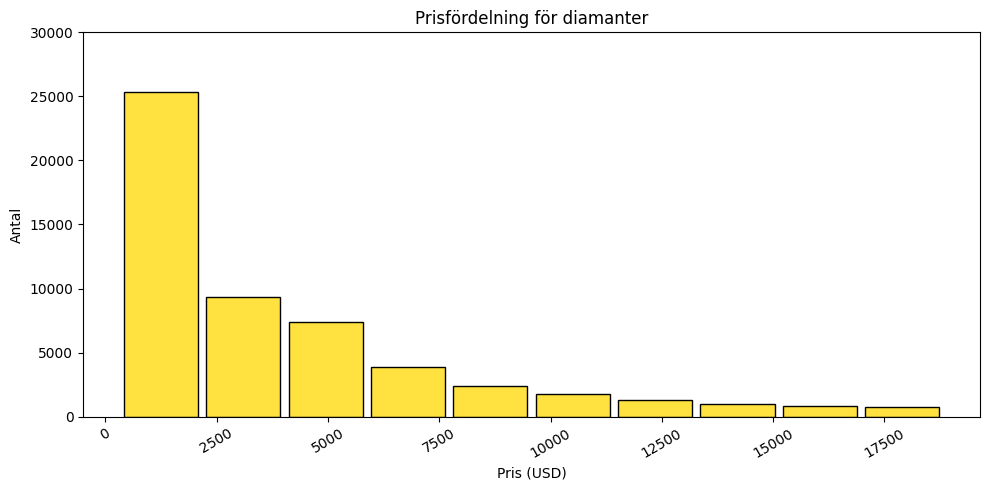

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(
    df_clean['price'],
    bins=10,
    color='gold',
    edgecolor='black',
    element='bars',     
    shrink=0.9           
)
plt.title('Prisfördelning för diamanter')
plt.xlabel('Pris (USD)')
plt.ylabel('Antal')
plt.xticks(rotation=30) 

ax = plt.gca()
yticks = ax.get_yticks()
ax.set_yticks([int(y) for y in yticks if y == int(y)])

plt.tight_layout()
plt.show()

### `Pris beroende på klarhet`

Här ser vi hur medelpriset varierar beroende på diamantens klarhetsgrad.  
Diamanter med bättre klarhet (som IF, VVS1) tenderar att ha ett högre pris.

/var/folders/j_/t4z7217s1yg0h55q9lythf880000gn/T/ipykernel_3671/1552373129.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price = df_clean.groupby('clarity')['price'].mean().reset_index().sort_values('price')


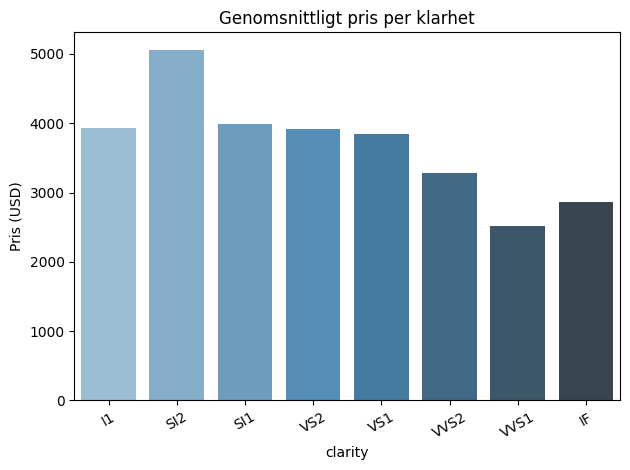

In [22]:
avg_price = df_clean.groupby('clarity')['price'].mean().reset_index().sort_values('price')

sns.barplot(data=avg_price, x='clarity', y='price', hue='clarity', dodge=False, palette='Blues_d', legend=False)
plt.title('Genomsnittligt pris per klarhet')
plt.ylabel('Pris (USD)')
plt.xticks(rotation=30)  
plt.tight_layout()
plt.show()

### `Pris beroende på carat (vikt)`

Priset ökar tydligt med carat. Denna plot visar att större stenar har ett betydligt högre genomsnittspris.  
Det är därför viktigt att väga in storlek vid investeringsbeslut.

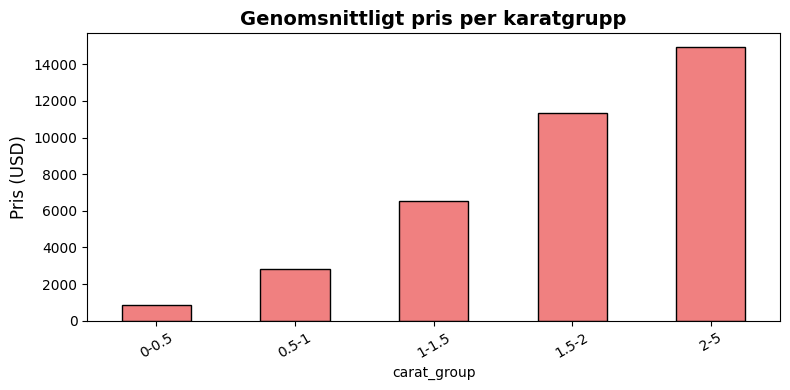

In [23]:
df_clean['carat_group'] = pd.cut(df_clean['carat'], bins=[0, 0.5, 1, 1.5, 2, 5], labels=['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-5'])
ax = df_clean.groupby('carat_group', observed=True)['price'].mean().plot(
    kind='bar', color='lightcoral', edgecolor='black', figsize=(8, 4))
ax.set_title('Genomsnittligt pris per karatgrupp', fontsize=14, fontweight='bold')
ax.set_ylabel('Pris (USD)', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### `Pris beroende på färg`

Denna barplot visar hur medelpriset skiljer sig mellan olika färggrader (D till J).  
Skillnaderna är mindre dramatiska än för carat och klarhet, men ändå märkbara.

/var/folders/j_/t4z7217s1yg0h55q9lythf880000gn/T/ipykernel_3671/1817947148.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df_clean.groupby('color')['price'].mean().sort_values().plot(


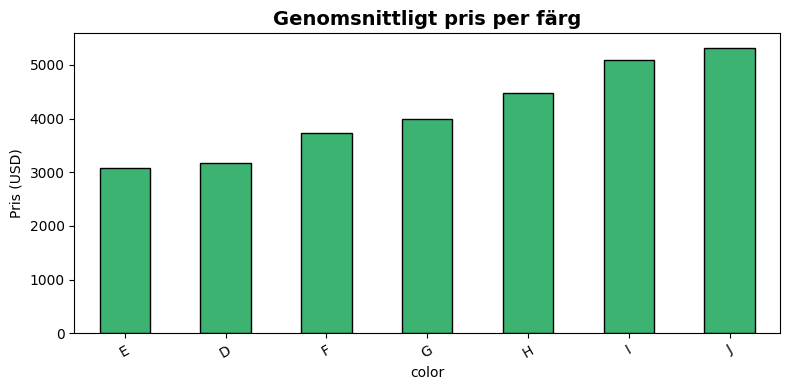

In [24]:
ax = df_clean.groupby('color')['price'].mean().sort_values().plot(
    kind='bar', color='mediumseagreen', edgecolor='black', figsize=(8, 4))
ax.set_title('Genomsnittligt pris per färg', fontsize=14, fontweight='bold')
ax.set_ylabel('Pris (USD)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## <span style="color:turquoise"> Samband mellan variabler </span>

För att förstå vilka faktorer som påverkar priset mest undersöker vi nu samband mellan olika variabler. Vi använder scatterplots och korrelationsmatris för att identifiera vilka egenskaper som har störst inverkan på diamantens pris.

---


### `Samband mellan carat och pris`

Här syns ett tydligt positivt samband: ju större diamanten är (i carat), desto högre pris.  
Dock ser vi också att det finns variation, inte alla stora diamanter är extremt dyra. Detta tyder på att även andra faktorer spelar in.

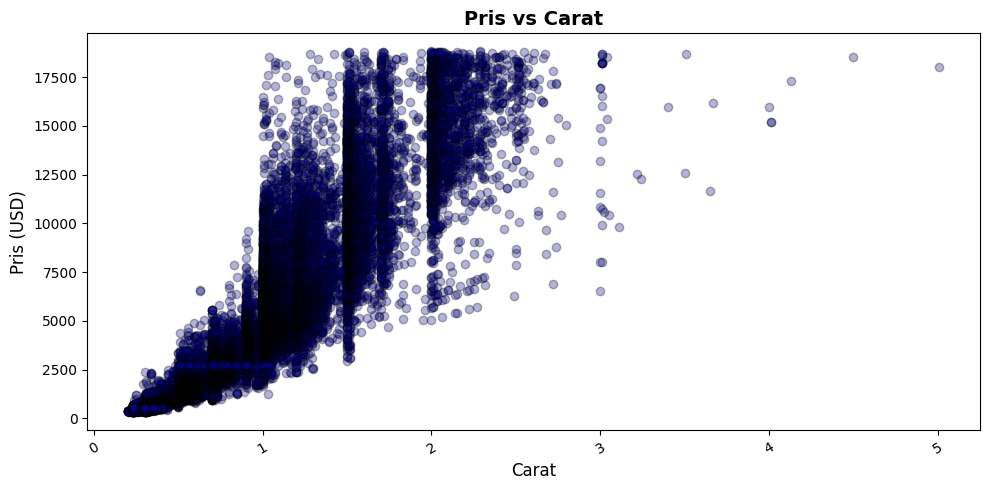

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(df_clean['carat'], df_clean['price'], alpha=0.3, color='darkblue', edgecolors='k')
plt.title('Pris vs Carat', fontsize=14, fontweight='bold')
plt.xlabel('Carat', fontsize=12)
plt.ylabel('Pris (USD)', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### `Pris vs fysiska mått`

Grafen visar att det finns ett tydligt samband mellan diamantens fysiska mått och pris, där särskilt längd (`x`) och bredd (`y`) har tydliga mönster.  
Även om dessa mått i sig är relaterade till carat, ger visualiseringen en mer konkret bild av diamantens volym och form i förhållande till värde.

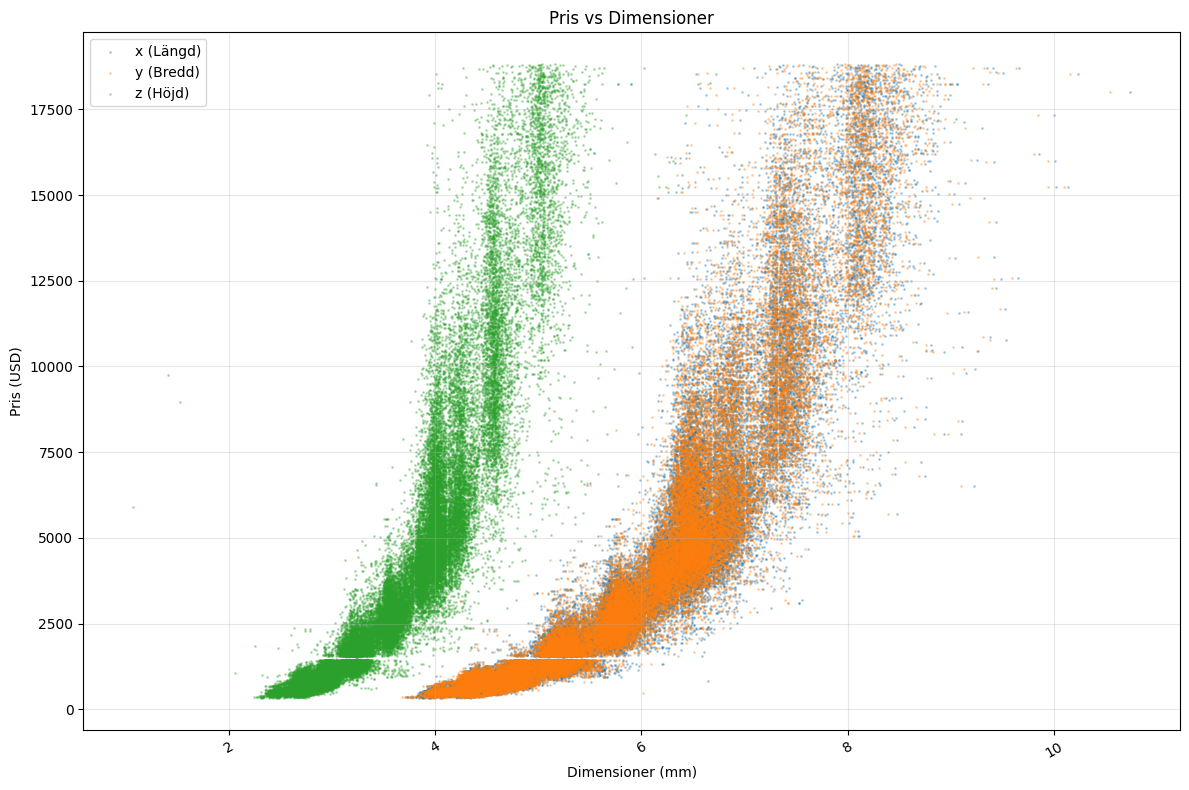

In [26]:
### Pris beroende på längd, bredd och höjd

plt.figure(figsize=(12, 8))
plt.scatter(df_clean['x'], df_clean['price'], alpha=0.3, s=1, label='x (Längd)')
plt.scatter(df_clean['y'], df_clean['price'], alpha=0.3, s=1, label='y (Bredd)')
plt.scatter(df_clean['z'], df_clean['price'], alpha=0.3, s=1, label='z (Höjd)')

plt.xlabel('Dimensioner (mm)')
plt.ylabel('Pris (USD)')
plt.title('Pris vs Dimensioner')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### `Diamanter per cut`

För att förstå hur diamanterna fördelar sig kvalitetsmässigt kan det vara intressant att visualisera hur stor andel av diamanterna som har varje typ av slipning (cut). Här passar ett cirkeldiagram bra.


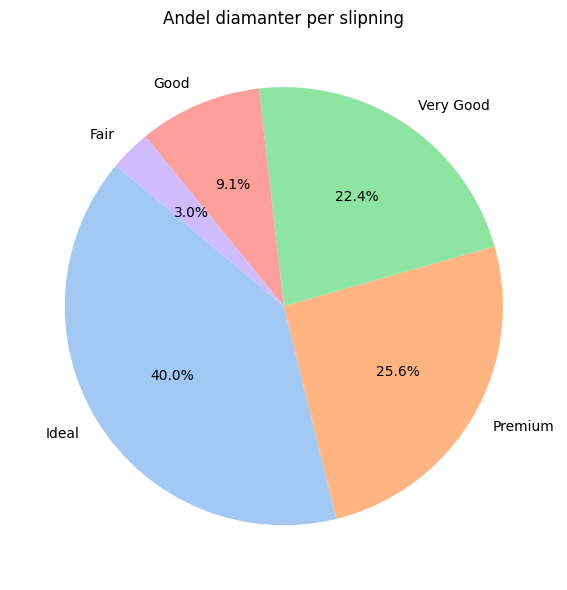

In [28]:
cut_counts = df_clean['cut'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(cut_counts, labels=cut_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Andel diamanter per slipning')
plt.tight_layout()
plt.show()

### `Tolkning av korrelationsmatrisen`

Vi kan se att **carat har stark positiv korrelation med pris** (ca +0.92), vilket bekräftar tidigare analyser.  
Fysiska mått som `x`, `y` och `z` visar också starkt samband med både carat och pris, vilket är väntat eftersom större stenar generellt väger mer.

`Cut`, `Clarity` och `Color` har svagare samband med pris (runt ±0.1–0.2), vilket antyder att dessa faktorer påverkar värdet i mindre grad jämfört med storlek.  
Det är även intressant att `depth` har ett svagt negativt samband med pris.

Totalt sett ger korrelationsmatrisen en överskådlig bild som bekräftar våra tidigare slutsatser vilket är att storlek är den mest avgörande faktorn för diamantpriset.

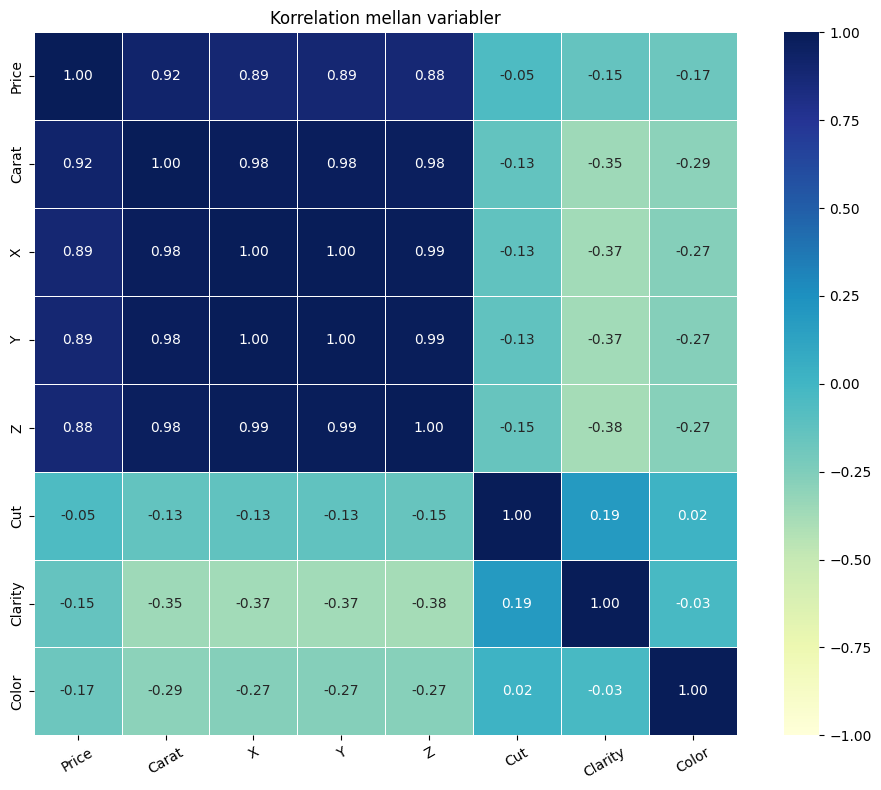

In [29]:
corr_df = df_clean[[
    'price', 'carat', 'x', 'y', 'z',
    'cut_encoded', 'clarity_encoded', 'color_encoded'
]].copy()

corr_df.columns = [
    'Price', 'Carat', 'X', 'Y', 'Z',
    'Cut', 'Clarity', 'Color'
]

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='YlGnBu',  # Ändrad färgskala
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt=".2f",
    square=True
)
plt.title("Korrelation mellan variabler")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## <span style="color:turquoise"> Upptäck dolda mönster – PCA & UMAP </span>

Utöver de vanliga sambanden kan det finnas mönster eller kluster i datan som inte syns i tvådimensionella diagram. Med hjälp av dimensionality reduction (PCA och UMAP) kan vi visualisera diamanterna i två dimensioner och upptäcka sådana mönster.

---


### `Dimensionality Reduction – Upptäck mönster med PCA och UMAP`

För att undersöka om det finns dolda mönster eller kluster i diamantdatan kan vi använda dimensionality reduction, t.ex. PCA och UMAP.  
Nedan visas en 2D-projektion av diamanterna med PCA, färglagd efter klarhet.

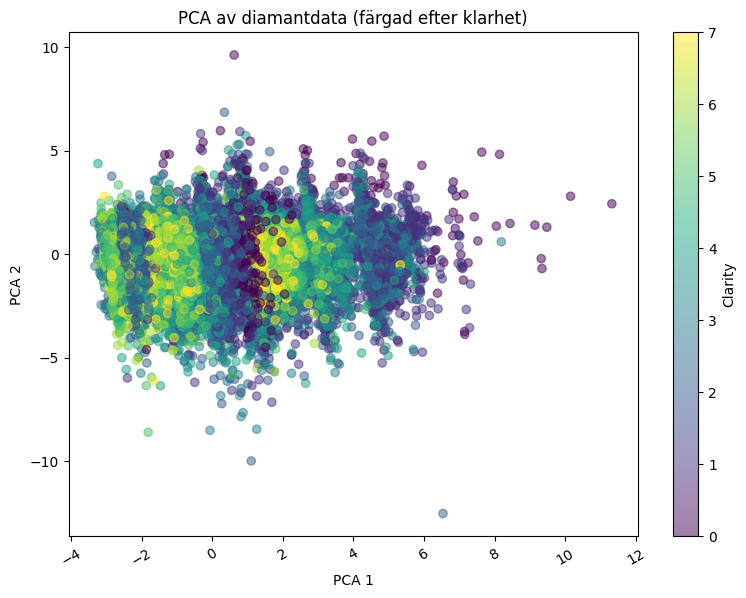

In [30]:
features = ['carat', 'depth', 'table', 'x', 'y', 'z']
X = StandardScaler().fit_transform(df_clean[features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_clean['clarity_encoded'], cmap='viridis', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA av diamantdata (färgad efter klarhet)')
plt.colorbar(scatter, label='Clarity')
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

/Users/user/mai24ma/AI_python/kunskapskontroll/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/mai24ma/AI_python/kunskapskontroll/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


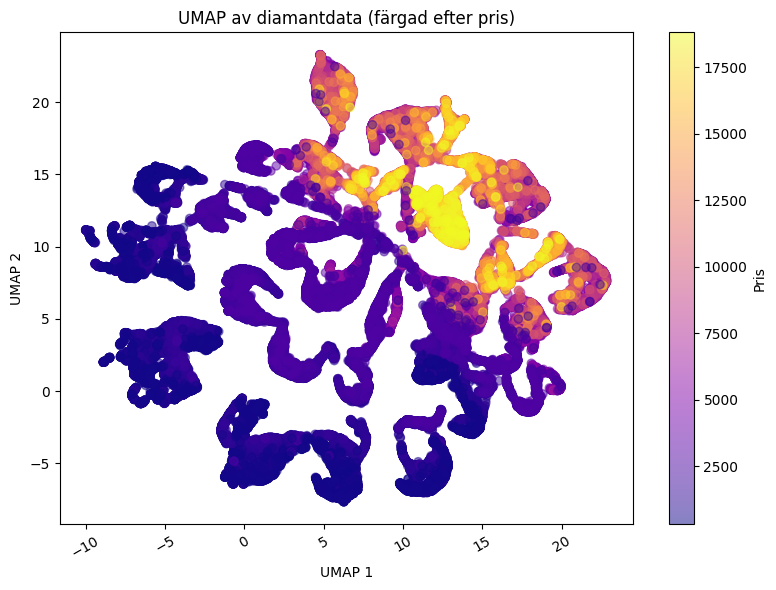

In [31]:
umap_model = umap.UMAP(n_neighbors=30, random_state=42)
X_umap = umap_model.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=df_clean['price'], cmap='plasma', alpha=0.5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP av diamantdata (färgad efter pris)')
plt.colorbar(scatter, label='Pris')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### `Spara ner den tvättade csv-filen`


In [18]:
df_clean.to_csv("diamonds_clean.csv", index=False)

## <span style="color:turquoise"> Sammanfattning och rekommendationer </span>

Slutligen sammanfattar vi de viktigaste insikterna från analysen och ger rekommendationer till Guldfynd inför ett eventuellt inträde på diamantmarknaden.

---


## <span style="color:turquoise"> Lärdomar & insikter </span>

- Det finns ett starkt samband mellan karat och pris. Större diamanter är betydligt dyrare.
- Klarhet och färg påverkar också pris, men inte lika mycket som carat.
- Cut påverkar hur attraktiv stenen är, men påverkar inte priset lika starkt som förväntat.

## <span style="color:turquoise"> Executive Summary </span>

- Pris påverkas mest av carat, följt av klarhet och färg.
- För att Guldfynd ska ge sig in på diamantmarknaden bör man överväga att fokusera på stenar med:
  - Hög carat (≥1.5), då dessa ger störst avkastning.
  - Klarhet VS1 eller bättre.
- Slipning är viktigt för utseende men mindre kritiskt för prisbilden.